In [1]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
from skforecast.datasets import fetch_dataset

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
pio.renderers.default = 'notebook' 
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
from skforecast.plot import plot_residuals
from skforecast.plot import plot_prediction_distribution
from pprint import pprint

# Modelling and Forecasting
# ==============================================================================
import skforecast
import sklearn
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import bayesian_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from sklearn.metrics import mean_pinball_loss
from scipy.stats import norm

# Configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

print(f"Version skforecast: {skforecast.__version__}")
print(f"Version sklearn:    {sklearn.__version__}")
print(f"Version lightgbm:   {lightgbm.__version__}")

Version skforecast: 0.12.1
Version sklearn:    1.4.2
Version lightgbm:   4.4.0


/home/plealm/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [2]:
data = pd.read_csv('../data/IPG2211A2N.csv')
data.head(2)

,DATE,IPG2211A2N
0,1962-01-01,24.3532
1,1962-02-01,23.7170


In [3]:
data['DATE'] = pd.to_datetime(data['DATE'], format='%Y-%m-%d')
data = data.set_index('DATE')
data = data.asfreq('MS')
data = data.sort_index()

In [4]:
# Split train-validation-test
# ==============================================================================
end_train = '1999-12-01'
end_validation = '2009-12-01'

data_train = data.loc[: end_train, :]
data_val   = data.loc[end_train:end_validation, :]
data_test  = data.loc[end_validation:, :]

print(f"Dates train      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Dates validacion : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Dates test       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")


Dates train      : 1962-01-01 00:00:00 --- 1999-12-01 00:00:00  (n=456)
Dates validacion : 1999-12-01 00:00:00 --- 2009-12-01 00:00:00  (n=121)
Dates test       : 2009-12-01 00:00:00 --- 2024-03-01 00:00:00  (n=172)


In [5]:
data_train

,IPG2211A2N
DATE,
1962-01-01,24.3532
1962-02-01,23.7170
1962-03-01,23.5643
1962-04-01,22.6991
1962-05-01,22.5973
...,...
1999-08-01,95.2565
1999-09-01,86.1813
1999-10-01,79.6564


In [6]:
# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['IPG2211A2N'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['IPG2211A2N'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['IPG2211A2N'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Number of IPG2211A2N',
    xaxis_title="Time",
    yaxis_title="Users",
    legend_title="Partition:",
    width=900,
    height=400,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1,
        xanchor="left",
        x=0.001
    )
)
fig.show()

/home/plealm/myenv/lib/python3.10/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning:

backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



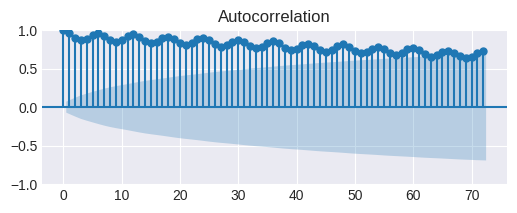

In [7]:
# Autocorrelation plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2))
plot_acf(data.IPG2211A2N, ax=ax, lags=24*3)
plt.show()

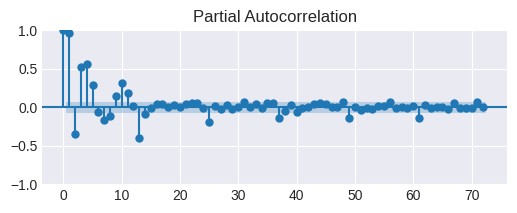

In [8]:
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2))
plot_pacf(data.IPG2211A2N, ax=ax, lags=24*3)
plt.show()

# Densidades - Random Forest

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

## Hyperparameter tuning

In [10]:
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['IPG2211A2N'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )



Number of models compared: 12.


lags grid: 100%|██████████| 2/2 [00:42<00:00, 21.34s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 5, 'n_estimators': 500}
  Backtesting metric: 21.469079203359517



In [11]:
results_grid

,lags,lags_label,params,mean_squared_error,max_depth,n_estimators
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",21.469079,5,500
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",21.728386,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",21.843942,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",22.178723,10,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",28.654859,3,100
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",29.051875,3,500
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",36.805377,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",37.742364,10,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",38.429631,5,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",45.158298,5,500


In [12]:
forecaster.fit(
    y     = data.loc[:end_validation, 'IPG2211A2N']
)

In [13]:
boot_predictions = forecaster.predict_bootstrapping(
                       steps  = 20,
                       n_boot = 25
                   )
boot_predictions

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_15,pred_boot_16,pred_boot_17,pred_boot_18,pred_boot_19,pred_boot_20,pred_boot_21,pred_boot_22,pred_boot_23,pred_boot_24
2010-01-01,109.382455,107.301914,104.206847,108.608517,105.459656,107.495436,108.755358,109.963902,108.592530,106.401124,...,110.044309,106.763944,109.028812,106.139406,105.032263,111.426777,107.947767,108.009065,109.467565,107.786883
2010-02-01,103.189828,103.323738,103.611253,105.548258,105.079928,104.137259,100.069401,105.398942,104.927396,108.285781,...,105.227964,104.880223,97.646352,104.817431,105.815471,104.092063,103.422473,102.319136,102.322631,103.855105
2010-03-01,95.078867,96.780464,96.012341,96.436964,96.334921,96.987612,96.550006,97.536100,102.754626,98.008421,...,97.661757,99.026729,95.803753,96.047310,98.263434,96.207005,96.470189,99.589698,95.578673,95.922616
2010-04-01,85.073091,86.220701,87.757322,94.341860,88.506469,89.067905,90.918150,89.448329,87.855366,87.685539,...,88.830798,90.991263,87.248526,87.966208,89.950258,88.434997,90.580967,90.542066,89.005602,89.573250
2010-05-01,90.322460,90.173516,86.740639,85.597706,89.672048,88.356951,86.089578,89.406715,87.757487,89.452688,...,89.250253,88.719349,89.501698,88.957978,89.536334,90.188734,89.077621,89.158326,90.031724,89.183123
2010-06-01,98.644231,100.514248,98.275207,100.906061,97.901459,102.450410,105.022115,98.581882,99.685692,97.913424,...,98.644196,102.372760,98.042195,98.258229,95.629301,99.187181,101.095708,99.942946,99.249618,97.921608
2010-07-01,106.430929,105.144568,106.057251,105.259558,105.905834,106.632250,105.890594,103.599516,107.749612,106.271114,...,104.489218,105.281427,106.420349,104.728430,102.475579,109.295431,106.077310,108.270691,106.090104,106.303858
2010-08-01,103.666799,106.219758,106.424165,104.752500,105.792428,106.520790,103.847614,108.931630,103.578345,106.034605,...,108.154644,105.237431,107.669773,104.656038,107.052323,105.223444,105.727562,103.292181,104.485013,110.404768
2010-09-01,96.969297,94.883066,96.832827,99.336929,99.362619,94.667871,97.930133,98.268742,95.101910,98.759740,...,99.095661,98.506302,96.953220,96.416172,99.136710,96.392266,99.981052,95.466302,98.268327,95.441849
2010-10-01,87.217145,88.765590,86.756285,90.709258,89.455552,91.032027,89.661774,90.265602,86.120026,86.504896,...,91.470971,91.133678,88.650380,90.650826,89.263985,89.365544,89.058382,86.371933,88.679760,93.462330


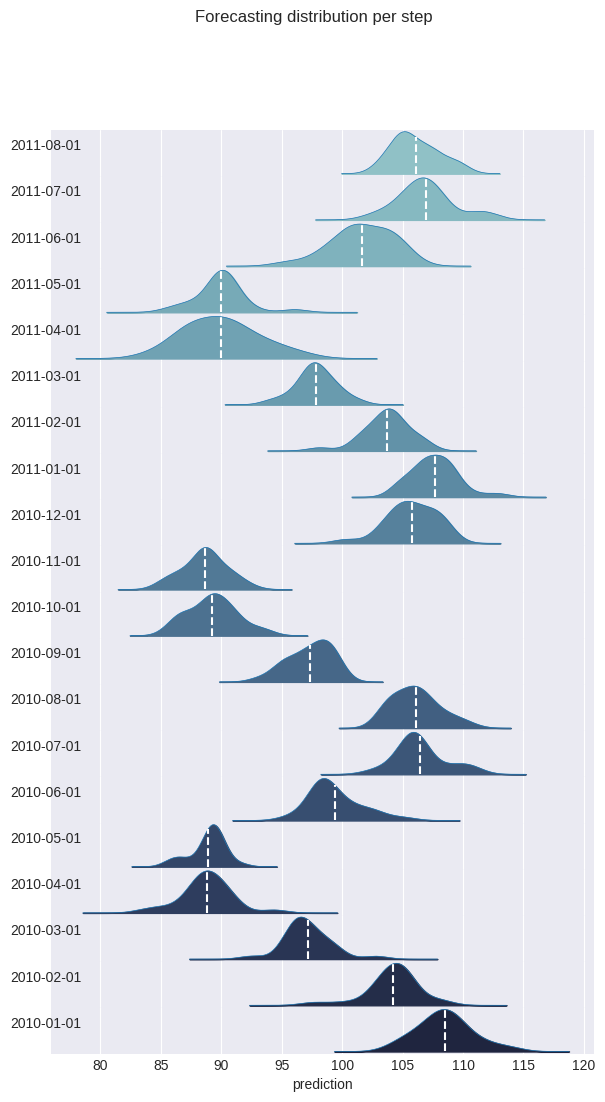

In [14]:
_ = plot_prediction_distribution(boot_predictions, figsize=(7, 12))

# Invervalos de Predicción Ridge

In [15]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
import skforecast
from skforecast.datasets import fetch_dataset
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings
print('Skforecast version: ', skforecast.__version__)

Skforecast version:  0.12.1


In [16]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 1, 1), # Placeholder replaced in the grid search
                                maxiter=500
                            )
             )

param_grid = {
    'order': [(0, 1, 0), (0, 1, 1), (1, 1, 0), (1, 1, 1), (2, 1, 1)],
    'seasonal_order': [(0, 0, 0, 0), (0, 1, 0, 12), (1, 1, 1, 12)],
    'trend': [None, 'n', 'c']
}

results_grid = grid_search_sarimax(
                   forecaster            = forecaster,
                   y                     = data.loc[:end_validation, 'IPG2211A2N'],
                   param_grid            = param_grid,
                   steps                 = 12,
                   refit                 = True,
                   metric                = 'mean_absolute_error',
                   initial_train_size    = len(data_train),
                   fixed_train_size      = False,
                   return_best           = False,
                   n_jobs                = 'auto',
                   suppress_warnings_fit = True,
                   verbose               = False,
                   show_progress         = True
               )
results_grid.head(5)

Number of models compared: 45.


params grid: 100%|██████████| 45/45 [04:52<00:00,  6.50s/it]


,params,mean_absolute_error,order,seasonal_order,trend
34,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",2.693123,"(1, 1, 1)","(1, 1, 1, 12)",n
33,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",2.693123,"(1, 1, 1)","(1, 1, 1, 12)",None
35,"{'order': (1, 1, 1), 'seasonal_order': (1, 1, ...",2.701083,"(1, 1, 1)","(1, 1, 1, 12)",c
42,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",2.705691,"(2, 1, 1)","(1, 1, 1, 12)",None
43,"{'order': (2, 1, 1), 'seasonal_order': (1, 1, ...",2.705691,"(2, 1, 1)","(1, 1, 1, 12)",n


In [ ]:
forecaster.fit(
    y     = data.loc[:end_validation, 'IPG2211A2N']
)

boot_predictions = forecaster.predict_bootstrapping(
                       steps  = 20,
                       n_boot = 25
                   )
boot_predictions

## Visualización de prediction bootstrap

,pred_boot_0,pred_boot_1,pred_boot_2,pred_boot_3,pred_boot_4,pred_boot_5,pred_boot_6,pred_boot_7,pred_boot_8,pred_boot_9,...,pred_boot_90,pred_boot_91,pred_boot_92,pred_boot_93,pred_boot_94,pred_boot_95,pred_boot_96,pred_boot_97,pred_boot_98,pred_boot_99
0,114.437065,125.452424,115.664054,123.939808,119.784479,114.401295,114.437065,114.827411,116.216803,116.776873,...,123.939808,125.353748,118.625585,113.618804,124.613002,117.122731,109.266579,106.262214,115.766746,112.195303


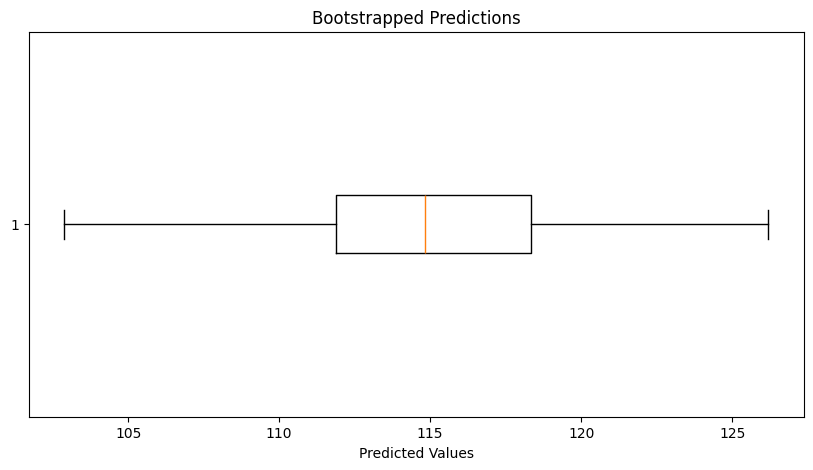

,Sample Index,Forecast,Sample Residual,Boot Predictions
0,9,115.081404,-0.644338,114.437065
1,83,115.081404,10.371021,125.452424
2,70,115.081404,0.582650,115.664054
3,47,115.081404,8.858405,123.939808
4,46,115.081404,4.703076,119.784479
5,92,115.081404,-0.680109,114.401295
6,9,115.081404,-0.644338,114.437065
7,75,115.081404,-0.253993,114.827411
8,21,115.081404,1.135400,116.216803
9,10,115.081404,1.695469,116.776873


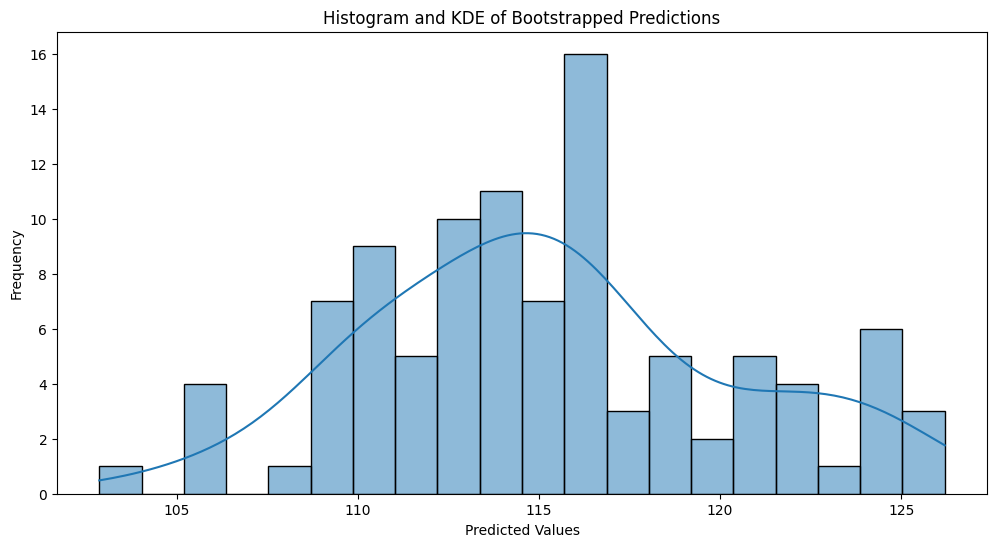

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from IPython.display import display, HTML

# Set random seeds for reproducibility
np.random.seed(42)
random.seed(42)

warnings.filterwarnings('ignore')

# Generate synthetic data
data = pd.read_csv('../../data/IPG2211A2N_1.csv')
data['DATE'] = pd.to_datetime(data['DATE'])
data.set_index('DATE', inplace=True)
data['IPG2211A2N'] = pd.to_numeric(data['IPG2211A2N'], errors='coerce')
data.dropna(inplace=True)

train = data[data.index.year < 2019]
test = data[data.index.year >= 2019]

def fit_arima_model(train_data):
    model = ARIMA(train_data, order=(5, 1, 0))
    fitted_model = model.fit()
    return fitted_model

def predict_bootstrapping(model, n_boot=10):
    predictions = model.forecast(steps=1).to_numpy().flatten()
    residuals = model.resid
    
    boot_predictions = np.full(n_boot, np.nan)
    rng = np.random.default_rng(seed=42)
    
    # Table to store the details of each bootstrap sample
    bootstrap_details = pd.DataFrame(columns=['Sample Index', 'Forecast', 'Sample Residual', 'Boot Predictions'])
    
    for i in range(n_boot):
        sample_index = rng.choice(len(residuals), size=1, replace=True)[0]
        sample_residual = residuals[sample_index]
        boot_prediction = predictions[-1] + sample_residual
        
        boot_predictions[i] = boot_prediction
        
        # Add the details to the table
        new_row = pd.DataFrame({
            'Sample Index': [sample_index],
            'Forecast': [predictions[-1]],
            'Sample Residual': [sample_residual],
            'Boot Predictions': [boot_prediction]
        })
        bootstrap_details = pd.concat([bootstrap_details, new_row], ignore_index=True)
    
    return pd.DataFrame(boot_predictions.reshape(1, -1), columns=[f"pred_boot_{i}" for i in range(n_boot)]), bootstrap_details

def plot_histogram_kde(bootstrap_predictions):
    plt.figure(figsize=(12, 6))
    sns.histplot(bootstrap_predictions.values.flatten(), kde=True, bins=20)
    plt.title('Histogram and KDE of Bootstrapped Predictions')
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency')
    plt.show()

# Fit the ARIMA model
model = fit_arima_model(train['IPG2211A2N'])

# Perform bootstrapping to generate predictions
bootstrap_predictions, bootstrap_details = predict_bootstrapping(model, n_boot=100)

# Display the full Bootstrap Predictions DataFrame
display(HTML("<h3>Bootstrap Predictions DataFrame:</h3>"))
display(bootstrap_predictions)

# Plot the bootstrap predictions
plt.figure(figsize=(10, 5))
plt.boxplot(bootstrap_predictions.values.flatten(), vert=False)
plt.title('Bootstrapped Predictions')
plt.xlabel('Predicted Values')
plt.show()


pd.set_option('display.max_columns', 10) #replace n with the number of columns you want to see completely
pd.set_option('display.max_rows', 101) #replace n with the number of rows you want to see completely

display(HTML("<h3>Bootstrap Details Table:</h3>"))
display(bootstrap_details)

# Plot histogram and KDE
plot_histogram_kde(bootstrap_predictions)

# Reset display options to default (optional)
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')